In [1]:
from astropy.time import Time, TimeDelta
from poliastro.twobody import Orbit
from poliastro.bodies import Earth
from astropy import units as u
import numpy as np
import matplotlib.pyplot  as plt
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(suppress=True, precision=6)

In [2]:
# Define the state transition function
def fx(x, dt):
    orbit = Orbit.from_vectors(Earth, x[:3] * u.km, x[3:] * u.km / u.s)
    orbit = orbit.propagate(TimeDelta(dt * u.s)) # seconds!
    new_pos, new_vel = orbit.r.to(u.km).value, orbit.v.to(u.km / u.s).value
    return np.hstack((new_pos, new_vel))

# Define the measurement function
def hx(x):
    return x

In [3]:
# reference: https://github.com/Al-khwarizmi-780/OpenKF/blob/main/python/examples/Square_Root_Unscented_Kalman_Filter.ipynb

import numpy as np

def cholupdate(L, W, beta):
    """ updating sqrt_cov directly """
    r = np.shape(W)[1]
    m = np.shape(L)[0]
    for i in range(r):
        L_out = np.copy(L)
        b = 1.0
        for j in range(m):
            Ljj_pow2 = L[j, j]**2
            wji_pow2 = W[j, i]**2
            #=============================================
            xxx = Ljj_pow2 + (beta / b) * wji_pow2
            if (xxx < 0):
                continue
            #=============================================
            L_out[j, j] = np.sqrt(xxx)
            upsilon = (Ljj_pow2 * b) + (beta * wji_pow2)
            for k in range(j+1, m):
                W[k, i] -= (W[j, i] / L[j,j]) * L[k,j]
                L_out[k, j] = ((L_out[j, j] / L[j, j]) * L[k,j]) + (L_out[j, j] * beta * W[j, i] * W[k, i] / upsilon)
            b += beta * (wji_pow2 / Ljj_pow2)
        L = np.copy(L_out)
    return L_out

def forwardsubs(A, B):
    """"""
    # x_ik = (b_ik - Sum_aij_xjk) / a_ii
    N = np.shape(A)[0]
    X = np.zeros((B.shape[0], B.shape[1]))
    for k in range(B.shape[1]):
        for i in range(N):
            sum_aij_xj = B[i, k]
            for j in range(i):
                sum_aij_xj -= A[i, j] * X[j, k]                
            X[i, k] = sum_aij_xj / A[i, i]
    return X

def backsubs(A, B):
    # x_ik = (b_ik - Sum_aij_xjk) / a_ii    
    N = np.shape(A)[0]
    X = np.zeros((B.shape[0], B.shape[1]))    
    for k in range(B.shape[1]):
        for i in range(N-1, -1, -1):
            sum_aij_xj = B[i, k]
            for j in range(N-1, i, -1):
                sum_aij_xj -= A[i, j] * X[j, k]
            X[i, k] = sum_aij_xj / A[i, i]
    return X

class SquareRootUKF(object):
    def __init__(self, x, P, Q, R):              
        self.dim_x = np.shape(x)[0]
        self.n_sigmas = (2 * self.dim_x) + 1
        
        self.kappa = 3 - self.dim_x
        
        self.sigma_scale = np.sqrt(self.dim_x + self.kappa)
        
        self.W0 = self.kappa / (self.dim_x + self.kappa)
        self.Wm = 0.5 / (self.dim_x + self.kappa)
        
        self.x = x
        
        # lower triangular matrices
        # print(f"init: p shape:{P.shape}")
        self.sqrt_P = np.linalg.cholesky(P) # sqrt of state cov mat
        # print(f"sqrt_P shape {self.sqrt_P.shape}")
        self.sqrt_Q = np.linalg.cholesky(Q) # sqrt of process noise
        self.sqrt_R = np.linalg.cholesky(R) # sqrt of meas noise
        # print(f'R = \n{R}\n')
    
    def predict(self, fx_prop, dt):
        # generate sigma points
        sigmas_X = self.sigma_points(self.x, self.sqrt_P)
        # print("first sigma points")
        # print(sigmas_X)
        
        # propagate sigma points through the nonlinear function
        for i in range(self.n_sigmas):
            sigmas_X[:, i] = fx_prop(sigmas_X[:, i], dt)
        
        # calculate weighted mean
        x_pred = self.W0 * sigmas_X[:, 0]
        for i in range(1, self.n_sigmas):
            x_pred += self.Wm * sigmas_X[:, i]
        
        # build compound matrix for square-root covariance update
        # sigmas_X[:, 0] is not added because W0 could be zero which will lead to undefined outcome from sqrt(W0).
        C = (sigmas_X[:, 1:].T - x_pred) * np.sqrt(self.Wm)
        C = np.concatenate((C, self.sqrt_Q.T), axis=0)
        
        # calculate square-root covariance S using QR decomposition of compound matrix C
        # including the process noise covariance
        Q , S_minus = np.linalg.qr(C)
        # print(f'Q = \n{Q}\n')
        # print(f'R = \n{S_minus}\n')
        
        # Rank-1 cholesky update
        x_dev = sigmas_X[:, 0] - x_pred  # get the deviation only from the sigma point
        x_dev = np.reshape(x_dev, [-1, 1])
        # print(f'x_dev = \n{x_dev}\n')
        S_minus = cholupdate(S_minus.T, x_dev, self.W0)
        
        # overwrite member x and S
        self.x = x_pred
        self.sqrt_P = S_minus
        
        # print(f'S^- = \n{S_minus}\n')
    
    
    def correct(self, hx, z):
        # generate sigma points X
        sigmas_X = self.sigma_points(self.x, self.sqrt_P)
        
        # propagate sigma points X through the nonlinear function
        # to get output sigma points Y
        dim_z = np.shape(z)[0]
        sigmas_Y = np.zeros((dim_z, self.n_sigmas))
        for i in range(self.n_sigmas):
            sigmas_Y[:, i] = hx(sigmas_X[:, i])
        
        # print(f'Ys = \n{sigmas_Y}\n')
        
        # calculate weighted mean y
        y_bar = self.W0 * sigmas_Y[:, 0]
        for i in range(1, self.n_sigmas):
            y_bar += self.Wm * sigmas_Y[:, i]
    
        # print(f'y = \n{y_bar}\n')
        
        # build compound matrix for square-root covariance update      
        C = (sigmas_Y[:, 1:].T - y_bar) * np.sqrt(self.Wm)       
        C = np.concatenate((C, self.sqrt_R.T), axis=0)
        
        # print(f'sqrt_R.T = \n{self.sqrt_R.T}\n')
        
        # calculate square-root covariance S using QR decomposition of compound matrix C
        # including the process noise covariance
        _ , S_y = np.linalg.qr(C)
        
        # Rank-1 cholesky update
        y_dev = sigmas_Y[:, 0] - y_bar
        y_dev = np.reshape(y_dev, [-1, 1])
        S_y = cholupdate(S_y.T, y_dev, self.W0)
        # print(f'Sy = \n{S_y}\n')
           
        # calculate cross-correlation
        Pxy = self.calculate_cross_correlation(self.x, sigmas_X, y_bar, sigmas_Y)
        # print(f'Pxy = \n{Pxy}\n')
        
        # Kalman gain calculation with two nested least-squares
        # Step1: Forward-substitution -> K = Sy \ Pxy  (since S_y is lower-triangular)
        # Step2: Backward-substitution -> K = Sy.T \ K (since S_y.T is upper-triangular)
        K = forwardsubs(S_y, Pxy)
        K = backsubs(S_y.T, K)
        # print(f'K = \n{K}\n')
        
        # update state vector x
        self.x += K @ (z - y_bar)
        
        # update state square-root covariance Sk
        # S_y must be upper triangular matrix at this place
        U = K @ S_y
        
        #self.sqrt_P = r_rank_cholupdate_v2(self.sqrt_P, U, -1.0)
        self.sqrt_P = cholupdate(self.sqrt_P, U, -1.0)
    
    
    def sigma_points(self, x, sqrt_P):
        
        '''
        generating sigma points matrix x_sigma given mean 'x' and square-root covariance 'S'
        '''
        # print(self.dim_x)
        sigmas_X = np.zeros((self.dim_x, self.n_sigmas))       
        # print(sigmas_X.shape)
        sigmas_X[:, 0] = x

        # print(sqrt_P.shape)
        # print(x.shape)

        for i in range(self.dim_x):
            idx_1 = i + 1
            idx_2 = i + self.dim_x + 1
            
            sigmas_X[:, idx_1] = x + (self.sigma_scale * sqrt_P[:, i])
            sigmas_X[:, idx_2] = x - (self.sigma_scale * sqrt_P[:, i])
            
        return sigmas_X
    
    
    def calculate_cross_correlation(self, x, x_sigmas, y, y_sigmas):
        xdim = np.shape(x)[0]
        ydim = np.shape(y)[0]
        
        n_sigmas = np.shape(x_sigmas)[1]
    
        dx = (x_sigmas[:, 0] - x).reshape([-1, 1])
        dy = (y_sigmas[:, 0] - y).reshape([-1, 1])
        Pxy = self.W0 * (dx @ dy.T)
        for i in range(1, n_sigmas):
            dx = (x_sigmas[:, i] - x).reshape([-1, 1])
            dy = (y_sigmas[:, i] - y).reshape([-1, 1])
            Pxy += self.Wm * (dx @ dy.T)
    
        return Pxy

In [11]:
npzfile = np.load('GPS_meas.npz', allow_pickle=True)

noisy_measurement = npzfile['measurements']
t_measurement = npzfile['t_measurements']
# Convert measurement times to Time objects
t_measurement_time = Time(t_measurement)

N = len(t_measurement) # Number of measurements.

# Calculate time intervals (dt) between consecutive measurements
dt_list = (t_measurement_time[1:] - t_measurement_time[:-1]) # TimeDelta object. Shape: (720,)

# Initial state vector
position = [3235.64171524, 2693.72565982, -5335.42793567] 
velocity = [-4.87430005, 5.89879341, 0.01977648] 
x = np.hstack((position, velocity)) # initial state vector. Shape: (6,)

# Process & measurement noise
P = np.eye(6)
Q = np.eye(6)*10**-6 # Process noise covariance. Shape: (6, 6)
R = np.eye(6)*10**2.5 # Measurement noise covariance. Shape: (6, 6)



In [12]:
sr_ukf = SquareRootUKF(x, P, Q, R)

states = []
for i in range (1, N):
    if (i % 100 == 0):
        print(f"Iteration {i}")
    
    sr_ukf.predict(fx, dt_list[i-1].sec)
    # print("state after pred")
    # print(sr_ukf.x)
    # print(sr_ukf.sqrt_P)
    sr_ukf.correct(hx, noisy_measurement[i])
    # print("state after corr")
    # print(sr_ukf.x)
    # print(sr_ukf.sqrt_P)
    states.append([sr_ukf.x])

states = np.concatenate(states)
print(states.shape)

Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
(720, 6)


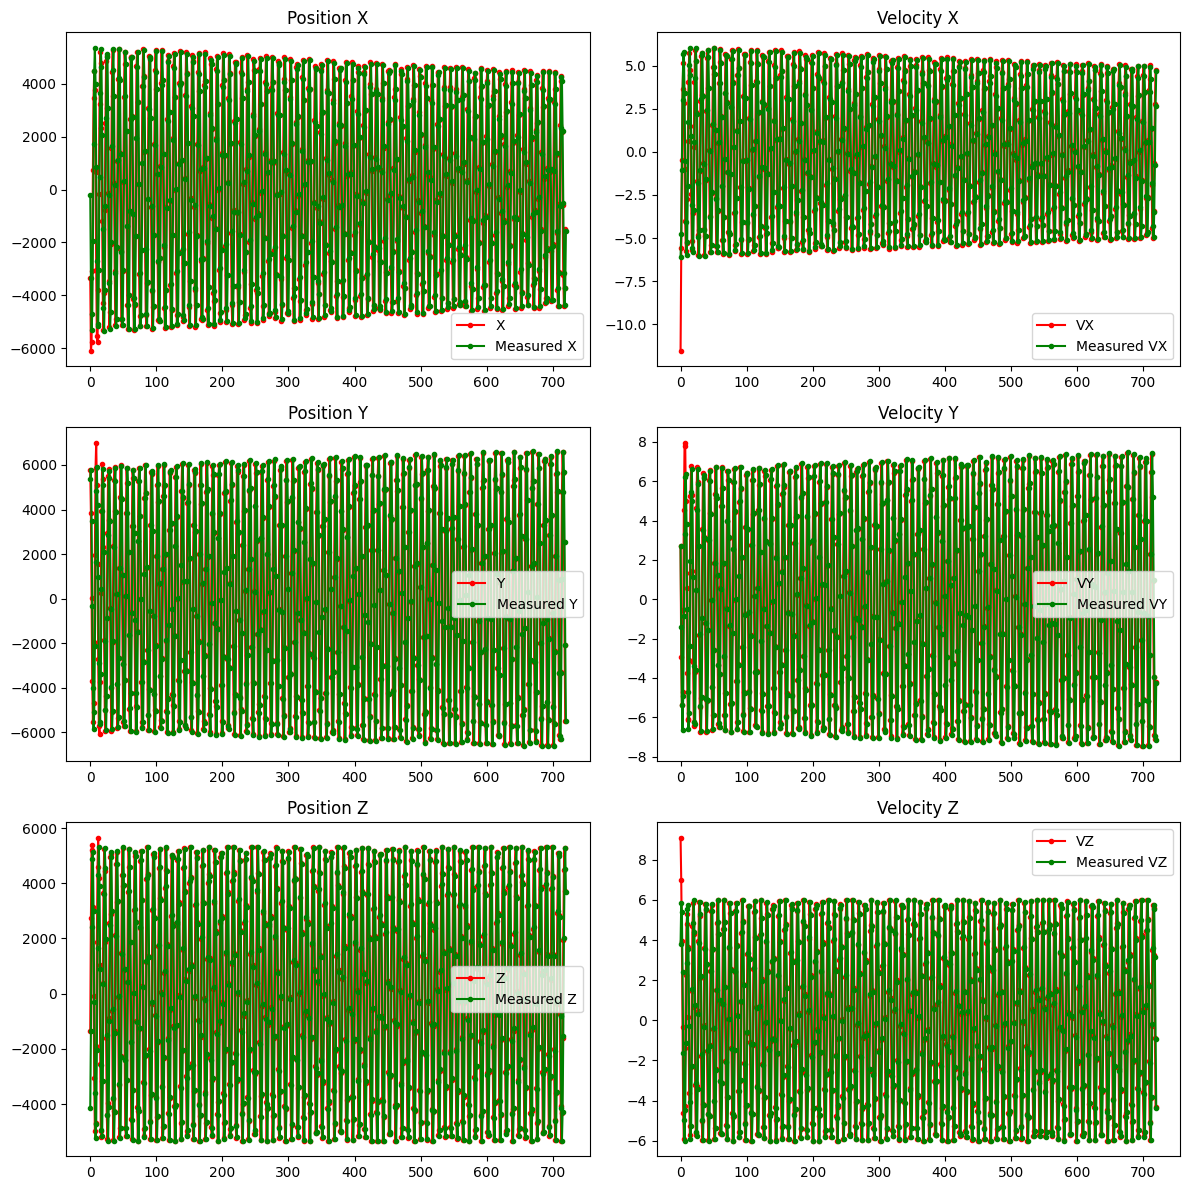

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].plot(states[:, 0], '.-', label='X', color='red')
axs[0, 0].plot(noisy_measurement[:, 0], '.-', label='Measured X', color='green')
axs[0, 0].set_title('Position X')
axs[0, 0].legend()

axs[1, 0].plot(states[:, 1], '.-', label='Y', color='red')
axs[1, 0].plot(noisy_measurement[:, 1], '.-', label='Measured Y', color='green')
axs[1, 0].set_title('Position Y')
axs[1, 0].legend()

axs[2, 0].plot(states[:, 2], '.-', label='Z', color='red')
axs[2, 0].plot(noisy_measurement[:, 2], '.-', label='Measured Z', color='green')
axs[2, 0].set_title('Position Z')
axs[2, 0].legend()

axs[0, 1].plot(states[:, 3], '.-', label='VX', color='red')
axs[0, 1].plot(noisy_measurement[:, 3], '.-', label='Measured VX', color='green')
axs[0, 1].set_title('Velocity X')
axs[0, 1].legend()

axs[1, 1].plot(states[:, 4], '.-', label='VY', color='red')
axs[1, 1].plot(noisy_measurement[:, 4], '.-', label='Measured VY', color='green')
axs[1, 1].set_title('Velocity Y')
axs[1, 1].legend()

axs[2, 1].plot(states[:, 5], '.-', label='VZ', color='red')
axs[2, 1].plot(noisy_measurement[:, 5], '.-', label='Measured VZ', color='green')
axs[2, 1].set_title('Velocity Z')
axs[2, 1].legend()

plt.tight_layout()
plt.show()